In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
##import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import sklearn
import re
import string
import pandas as pd
import seaborn as sns

In [3]:
#training data
train_data=pd.read_csv('../input/nlp-getting-started/train.csv')


In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#drop columns
train_data.drop(['id','keyword','location'],axis=1,inplace=True)

In [7]:
##null values
train_data.isnull().sum()

text      0
target    0
dtype: int64

## let's do some EDA

<AxesSubplot:ylabel='target'>

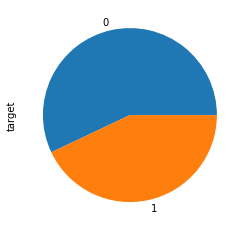

In [8]:
train_data['target'].value_counts().plot.pie()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


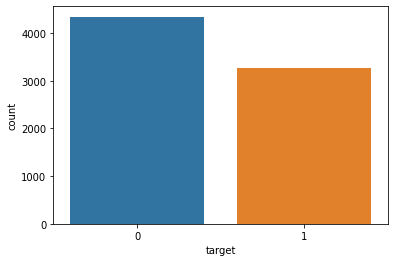

In [9]:
sns.countplot(train_data['target'])
plt.show()

In [10]:
##divide into x and y
X=train_data.drop('target',axis=1)

In [11]:
y=train_data['target']

In [12]:
##remove punctuations,stop words
from nltk.stem import WordNetLemmatizer
#ps = PorterStemmer()
wn=WordNetLemmatizer()
corpus=[]
for i in range(0,len(X)):
    review=re.sub('[^a-zA-Z]',' ',X['text'][i])
    review=review.lower()
    review=review.split()
    review=[wn.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review= ' '.join(review)
    corpus.append(review)

In [13]:
len(corpus),X.shape,len(y)

(7613, (7613, 1), 7613)

In [14]:
corpus[2]

'resident asked shelter place notified officer evacuation shelter place order expected'

In [15]:
##train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(corpus,y,test_size=0.2,random_state=42)

In [16]:
len(X_train),len(y_train)

(6090, 6090)

In [17]:
##using tokenizer of bert
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [18]:
##tokenize function
def tokenize_text(data):
    encoded=tokenizer(data,padding=True,truncation=True,return_tensors='np')
    return encoded.data
        
        

In [19]:
##tokenize train_data
train_data=tokenize_text(X_train)

In [20]:

train_data['input_ids'].shape,y_train.shape

((6090, 45), (6090,))

In [21]:
#tokenize test_data
test_data=tokenize_text(X_test)

In [22]:
test_data['input_ids'].shape,y_test.shape

((1523, 41), (1523,))

In [23]:
##import pretrained model
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [25]:
##training 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss,metrics=['accuracy'])
model.fit(
    train_data,
    np.array(y_train), 
    validation_data=(
        test_data,
        np.array(y_test),
    ),
    batch_size=32,epochs=10
)

Epoch 1/10
191/191 [==============================] - 39s 126ms/step - loss: 0.5109 - accuracy: 0.7586 - val_loss: 0.4043 - val_accuracy: 0.8280
Epoch 2/10
191/191 [==============================] - 22s 115ms/step - loss: 0.3430 - accuracy: 0.8597 - val_loss: 0.4566 - val_accuracy: 0.7905
Epoch 3/10
191/191 [==============================] - 22s 116ms/step - loss: 0.2307 - accuracy: 0.9067 - val_loss: 0.5237 - val_accuracy: 0.8050
Epoch 4/10
191/191 [==============================] - 22s 116ms/step - loss: 0.1395 - accuracy: 0.9481 - val_loss: 0.6100 - val_accuracy: 0.7997
Epoch 5/10
191/191 [==============================] - 22s 115ms/step - loss: 0.0797 - accuracy: 0.9704 - val_loss: 0.7543 - val_accuracy: 0.7807
Epoch 6/10
191/191 [==============================] - 22s 116ms/step - loss: 0.0670 - accuracy: 0.9712 - val_loss: 0.8740 - val_accuracy: 0.7873
Epoch 7/10
191/191 [==============================] - 22s 116ms/step - loss: 0.0584 - accuracy: 0.9763 - val_loss: 0.9671 - val_ac

In [26]:
##saving model
model.save_pretrained('bert_79')

In [27]:
preds=model.predict(test_data)

In [29]:
classes=np.argmax(preds['logits'],axis=1)

In [30]:
##accuracy
from sklearn import metrics
metrics.accuracy_score(classes,y_test)

0.7912015758371634

In [31]:
#confusion matrix
metrics.confusion_matrix(classes,y_test)

array([[716, 160],
       [158, 489]])

In [32]:
##roc auc
metrics.roc_auc_score(classes,y_test)

0.7865737898131877

In [39]:
from sklearn.metrics import classification_report
print(classification_report(classes,y_test))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       876
           1       0.75      0.76      0.75       647

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [33]:
##lets reduce lr during traininig
from tensorflow.keras.optimizers.schedules import PolynomialDecay
batch_size = 32
num_epochs = 3
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs
num_train_steps = (len(train_data)// batch_size) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
    )
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=lr_scheduler)

In [34]:
import tensorflow as tf
model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [36]:
##training
model2.compile(
    optimizer=opt,
    loss=model.compute_loss,
    metrics=['accuracy'],
)
model.fit(train_data,
    np.array(y_train), 
    validation_data=(test_data,
        np.array(y_test),
    ),
    batch_size=32,epochs=10
)

Epoch 1/10
191/191 [==============================] - 22s 116ms/step - loss: 0.0307 - accuracy: 0.9867 - val_loss: 1.0748 - val_accuracy: 0.8043
Epoch 2/10
191/191 [==============================] - 22s 117ms/step - loss: 0.0262 - accuracy: 0.9885 - val_loss: 1.0776 - val_accuracy: 0.7991
Epoch 3/10
191/191 [==============================] - 22s 115ms/step - loss: 0.0271 - accuracy: 0.9892 - val_loss: 1.0697 - val_accuracy: 0.7945
Epoch 4/10
191/191 [==============================] - 22s 116ms/step - loss: 0.0217 - accuracy: 0.9903 - val_loss: 1.2374 - val_accuracy: 0.8063
Epoch 5/10
191/191 [==============================] - 22s 117ms/step - loss: 0.0205 - accuracy: 0.9901 - val_loss: 1.2335 - val_accuracy: 0.8004
Epoch 6/10
191/191 [==============================] - 22s 115ms/step - loss: 0.0204 - accuracy: 0.9921 - val_loss: 1.2593 - val_accuracy: 0.7649
Epoch 7/10
191/191 [==============================] - 22s 116ms/step - loss: 0.0129 - accuracy: 0.9936 - val_loss: 1.2629 - val_ac

In [40]:
##save
model2.save_pretrained('bert_80')

In [41]:
preds=model.predict(test_data)

In [42]:
classes=np.argmax(preds['logits'],axis=1)

In [43]:
##confusion matrix
metrics.confusion_matrix(classes,y_test)

array([[727, 154],
       [147, 495]])

In [44]:
metrics.roc_auc_score(classes,y_test)

0.7981133376473208

In [45]:
from sklearn.metrics import classification_report
print(classification_report(classes,y_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       881
           1       0.76      0.77      0.77       642

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



In [47]:
##making predictions
pred_data=pd.read_csv('../input/nlp-getting-started/test.csv')

In [48]:
pred_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [50]:
pred_data.drop(['id','keyword','location'],axis=1,inplace=True)

In [52]:
pred_data.columns

Index(['text'], dtype='object')

In [54]:
##null values
pred_data.isnull().sum()

text    0
dtype: int64

In [56]:
##remove stop words and punctuations
from nltk.stem import WordNetLemmatizer
#ps = PorterStemmer()
wn=WordNetLemmatizer()
corpus=[]
for i in range(0,len(pred_data)):
    review=re.sub('[^a-zA-Z]',' ',pred_data['text'][i])
    review=review.lower()
    review=review.split()
    review=[wn.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review= ' '.join(review)
    corpus.append(review)

In [57]:
len(corpus)

3263

In [58]:
pred_data=tokenize_text(corpus)

In [59]:
pred_data['input_ids'].shape

(3263, 44)

In [77]:
##predictions
preds=model.predict(pred_data)

In [78]:
classes=np.argmax(preds['logits'],axis=1)
classes

array([1, 1, 1, ..., 1, 1, 1])

In [79]:
##submission file
submisssions=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [80]:
submisssions.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [81]:
##pass our predicted values
submisssions['target']=classes

In [82]:
submisssions['target'].value_counts()

0    1977
1    1286
Name: target, dtype: int64

In [83]:
##csv file
submisssions.to_csv('submission1.csv',index = False);

<a href="./submission1.csv"> Download File </a>